In [ ]:
!apt-get update
!pip3 install scikit-image==0.16.2
!pip3 install opencv-python
!pip3 install tensorflow-gpu==2.0.0
!pip3 install keras==2.3.1
!pip install h5py==2.10.0

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [910 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelea

In [ ]:
!git clone https://github.com/ahmedfgad/Mask-RCNN-TF2.git

Cloning into 'Mask-RCNN-TF2'...
remote: Enumerating objects: 1440, done.
remote: Total 1440 (delta 0), reused 0 (delta 0), pack-reused 1440
Receiving objects: 100% (1440/1440), 156.99 MiB | 38.61 MiB/s, done.
Resolving deltas: 100% (796/796), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd Mask-RCNN-TF2/

/content/Mask-RCNN-TF2


In [ ]:
import mrcnn
import mrcnn.utils
import mrcnn.config
import mrcnn.model

import urllib.request

import os
import xml.etree
from numpy import zeros, asarray

class RoadsignDataset(mrcnn.utils.Dataset):

    def load_dataset(self, dataset_dir, is_train=True):
        self.add_class("dataset", 1, "trafficlight")
        self.add_class("dataset", 2, "stop")
        self.add_class("dataset", 3, "speedlimit")
        self.add_class("dataset", 4, "crosswalk")


        


        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'

        for filename in os.listdir(images_dir):
            image_id = filename[:-4]

            if is_train and int(image_id) >= 800:
                continue

            if not is_train and int(image_id) < 800:
                continue

            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'

            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path,class_ids=[0,1,2,3,4])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['annotation']
        boxes, w, h, name = self.extract_boxes(path)
        masks = zeros([h, w, len(boxes)], dtype='uint8')

        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            if (name == 'trafficlight'):
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('trafficlight'))
            elif(name == 'stop'):
                masks[row_s:row_e, col_s:col_e, i] = 2
                class_ids.append(self.class_names.index('stop')) 
            elif(name == 'speedlimit'):
                masks[row_s:row_e, col_s:col_e, i] = 3
                class_ids.append(self.class_names.index('speedlimit'))
            else:
                masks[row_s:row_e, col_s:col_e, i] = 4
                class_ids.append(self.class_names.index('crosswalk'))

        return masks, asarray(class_ids, dtype='int32')


    # A helper method to extract the bounding boxes from the annotation file
    def extract_boxes(self, filename):
        tree = xml.etree.ElementTree.parse(filename)

        root = tree.getroot()

        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)

        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        name = root.find('.//object/name').text

        return boxes, width, height, name

class RoadsignConfig(mrcnn.config.Config):
    NAME = "Roadsign_cfg"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    NUM_CLASSES = 5
    
    LEARNING_RATE = 0.002

    STEPS_PER_EPOCH = 25

Roadsign_config = RoadsignConfig()

# Train
train_dataset = RoadsignDataset()
train_dataset.load_dataset(dataset_dir='/content/drive/MyDrive/update-dataset', is_train=True)
train_dataset.prepare()

# Validation
validation_dataset = RoadsignDataset()
validation_dataset.load_dataset(dataset_dir='/content/drive/MyDrive/update-dataset', is_train=False)
validation_dataset.prepare()

model = mrcnn.model.MaskRCNN(mode='training', 
                             model_dir='./log', 
                             config=Roadsign_config)
model.keras_model.summary()

urllib.request.urlretrieve("https://github.com/matterport/Mask_RCNN/releases/download/v1.0/mask_rcnn_coco.h5", "mask_rcnn_coco.h5")

model.load_weights(filepath='mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
print("Weights loaded!")

model.train(train_dataset=train_dataset, 
            val_dataset=validation_dataset, 
            learning_rate=Roadsign_config.LEARNING_RATE, 
            epochs=10, 
            layers='heads')

model_path = 'Roadsign_mask_rcnn_trained.h5'
model.keras_model.save_weights(model_path)

Using TensorFlow backend.


Model: "mask_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multi

Epoch 1/10
25/25 [==============================] - 77s 3s/step - loss: 2.9540 - val_loss: 1.1439
Epoch 2/10
25/25 [==============================] - 34s 1s/step - loss: 1.1485 - val_loss: 0.8745
Epoch 3/10
25/25 [==============================] - 34s 1s/step - loss: 0.9813 - val_loss: 2.6275
Epoch 4/10
25/25 [==============================] - 35s 1s/step - loss: 0.8293 - val_loss: 1.1115
Epoch 5/10
25/25 [==============================] - 34s 1s/step - loss: 0.6393 - val_loss: 0.7876
Epoch 6/10
25/25 [==============================] - 33s 1s/step - loss: 0.7797 - val_loss: 0.3046
Epoch 7/10
25/25 [==============================] - 34s 1s/step - loss: 0.5479 - val_loss: 2.7639
Epoch 8/10
25/25 [==============================] - 34s 1s/step - loss: 0.7513 - val_loss: 0.7431
Epoch 9/10
25/25 [==============================] - 32s 1s/step - loss: 0.7938 - val_loss: 0.7313
Epoch 10/10
25/25 [==============================] - 33s 1s/step - loss: 0.3948 - val_loss: 0.8104


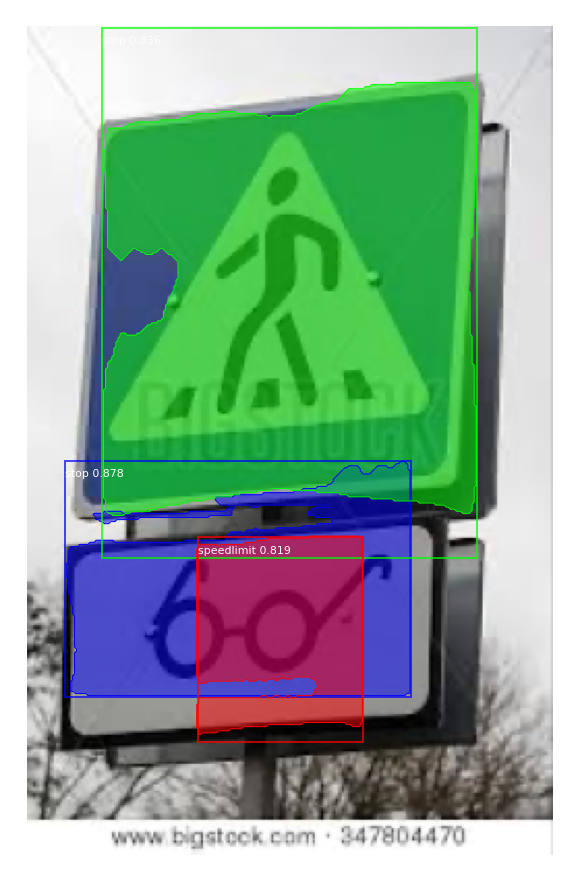

In [ ]:
import mrcnn
import mrcnn.config
import mrcnn.model
import mrcnn.visualize
import cv2
import os

CLASS_NAMES = ['BG', 'trafficlight','stop',"speedlimit","crosswalk"]

class SimpleConfig(mrcnn.config.Config):
    NAME = "coco_inference"
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    NUM_CLASSES = len(CLASS_NAMES)

model = mrcnn.model.MaskRCNN(mode="inference", 
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

model.load_weights(filepath="Roadsign_mask_rcnn_trained.h5", 
                   by_name=True)

image = cv2.imread("/content/drive/MyDrive/update-dataset/images/96.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

r = model.detect([image], verbose=0)

r = r[0]

mrcnn.visualize.display_instances(image=image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'], 
                                  class_names=CLASS_NAMES, 
                                  scores=r['scores'])